_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: Luca Kosina, Sascha Mühlinghaus, Max Bardelang

LLM Disclaimer: Copilot for generating repetitive code in plotting , boilerplate code and nasty indexing tasks

<!-- Always use $...$ for inline math and $$...$$ for display math in Markdown cells. -->

# Coding Lab 6

In this exercise we are going to fit a latent variable model (Poisson GPFA) to both toy data and real data from monkey primary visual cortex. For details, see [Ecker et al. 2014](https://www.cell.com/neuron/pdf/S0896-6273(14)00104-4.pdf).

## Preliminaries

### 1. Code 

The toolbox we are going to use contains an implementation of the EM algorithm to fit the poisson-gpfa. 

Assuming you `git clone https://github.com/berenslab/poisson-gpfa` to the parent directory and have the following directory structure:


```
├── data/
│   └── nds_cl_6_data.mat
├── poisson-gpfa/
├── notebooks
│   └── CodingLab6.ipynb
├── matplotlib_style.txt
├── requirements.txt
```

then you can import the related functions via:

```
import sys
sys.path.append('../poisson-gpfa/')
sys.path.append('../poisson-gpfa/funs')

import funs.util as util
import funs.engine as engine
```

Change the paths if you have a different directory structure. For the details of the algorithm, please refer to the thesis `hooram_thesis.pdf` from ILIAS.

### 2. Data

Download the data file ```nds_cl_6_data.mat``` from ILIAS and save it in a ```data/``` folder.

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# style
import seaborn as sns

# poisson-gpfa
import sys
sys.path.append('../poisson-gpfa/')
sys.path.append('../poisson-gpfa/funs')

import funs.util as util
import funs.engine as engine

In [2]:
%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-31 17:05:37CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.36.0

sklearn: 1.6.1

seaborn   : 0.13.2
sys       : 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]
numpy     : 2.0.1
scipy     : 1.13.1
matplotlib: 3.10.1

Watermark: 2.5.0



In [3]:
plt.style.use("../matplotlib_style.txt")

## Task 1. Generate some toy data to test the poisson-GPFA code

We start by verifying our code on toy data. The cell below contains code to generate data for 30 neurons, 100 trials (1000 ms each) and 50ms bin size. The neurons' firing rate $\lambda_k$ is assumed to be a constant $d_k$ modulated by a one-dimensional latent state $x$, which is drawn from a Gaussian process:

$\lambda_k = \exp(c_kx + d_k)$

Each neuron's weight $c_k$ is drawn randomly from a normal distribution and spike counts are sampled form a Poisson distribution with rate $\lambda_k$.

Your task is to fit a Poisson GPFA model with one latent variable to this data (see `engine.PPGPFAfit`).

Hint: You can use `util.dataset?`, `engine.PPGPFAfit?` or `util.initializeParams?` to find out more about the provided package.

*Grading: 3 pts*

GPFA gaussian process factor analysis

In [4]:
# ---------------------------------
# simulate a training set (0.5 pts)
# ---------------------------------


# Initialize random number generator
np.random.seed(420)

# Specify dataset & fitting parameters
xdim = 1  # number of latent dimensions
ydim = 30  # number of neurons


# Sample from the model (make a toy dataset)
training_set = util.dataset(
    trialDur=1000,
    binSize=50,
    numTrials=100,
    xdim=xdim,
    ydim=ydim,
    seed=42,
)

+------------- Simulated Dataset Options -------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                 1000 | Duration of trials (ms):
                                                   50 | Size of bins (ms):
                                                  100 | Number of Trials
+-----------------------------------------------------+
Sampling trial 100 ...
Average firing rate per neuron in this dataset: 3.431 Hz.


### Fit the model

In [5]:
# -----------------------
# fit the model (0.5 pts)
# -----------------------

# Initialize parameters using Poisson-PC
initial_params = util.initializeParams(xdim=xdim, ydim=ydim, experiment=training_set)

# choose sensible parameters and run fit
fitToy = engine.PPGPFAfit(training_set, initial_params, xdim=xdim, EMmode="Batch")

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                   50 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:  50 of  50, nPLL: = -261.0289
This dataset is a simulated dataset.
Processing performance against ground truth parameters...


In [6]:
# some useful functions
def allTrialsState(fit: engine.PPGPFAfit, p) -> np.ndarray:
    """Reshape the latent signal and the spike counts"""
    x = np.zeros([p, 0])
    for i in range(len(fit.infRes["post_mean"])):
        x = np.concatenate((x, fit.infRes["post_mean"][i]), axis=1)
    return x


def allTrialsX(training_set: util.dataset) -> np.ndarray:
    """Reshape the ground truth
    latent signal and the spike counts"""
    x_gt = np.array([])
    for i in range(len(training_set.data)):
        x_gt = np.concatenate((x_gt, training_set.data[i]["X"][0]), axis=0)
    return x_gt

### Plot the ground truth vs. inferred model
Verify your fit by plotting both ground truth and inferred parameters for:
1. weights C
2. biases d
3. latent state x 

Note that the sign of fitted latent state and its weights are ambiguous (you can flip both without changing the model). Make sure you correct the sign for the plot if it does not match the ground truth.

In [7]:
# All trials latent state vector
x_est = allTrialsState(fitToy, 1)
x_true = allTrialsX(training_set)
print("original", x_est.shape, x_true.shape)

# reshape
x_est = x_est.reshape(20, -1)  # (T, n_trials)
x_true = x_true.reshape(20, -1)  # (T, n_trials)
print("reshaped", x_est.shape, x_true.shape)


# randomly select 20 trials
idx = np.random.choice(x_est.shape[1], 10, replace=False)
x_est = x_est[:, idx]
x_true = x_true[:, idx]
print("randomly selected", x_est.shape, x_true.shape)

# add vertical offset to latent states
x_est += 5.0 * np.arange(x_est.shape[1])
x_true += 5.0 * np.arange(x_true.shape[1])

original (1, 2000) (2000,)
reshaped (20, 100) (20, 100)
randomly selected (20, 10) (20, 10)


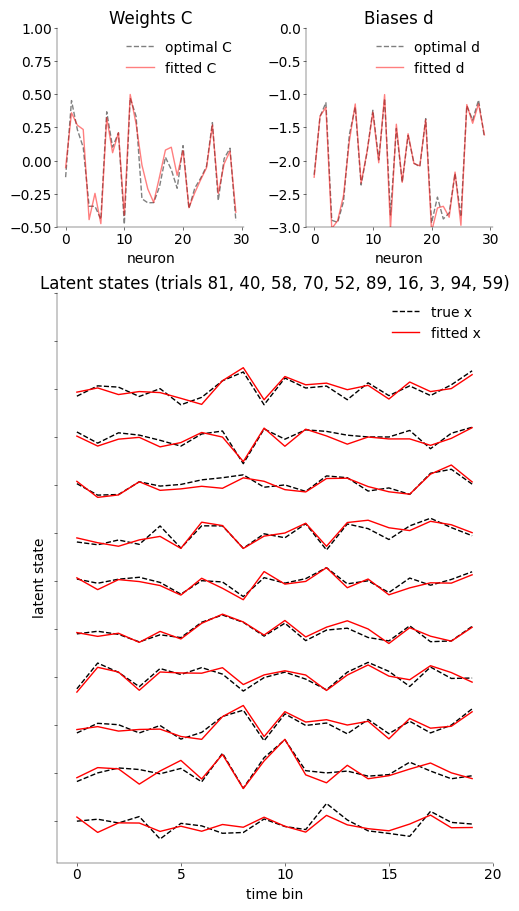

In [8]:
from matplotlib.gridspec import GridSpec

# ------------------------------------------------------
# Plot ground truth vs. inferred model
# Plot the weights `C`, biases `d` and latent states (2 pts)
# ------------------------------------------------------

fig = plt.figure(figsize=(5, 9))
gs = GridSpec(2, 2, height_ratios=[0.7, 2.0], figure=fig)
ax_C = fig.add_subplot(gs[0, 0])
ax_d = fig.add_subplot(gs[0, 1])
ax_latent = fig.add_subplot(gs[1, :])
ax = {"C": ax_C, "d": ax_d, "latent": ax_latent}


ax["C"].set_title("Weights C")
ax["C"].plot(training_set.params["C"], "k--", label="optimal C", alpha=0.5)
ax["C"].plot(fitToy.optimParams["C"], "r", label="fitted C", alpha=0.5)
ax["C"].legend(loc="upper right")
ax["C"].set_xlabel("neuron")
ax["C"].set_ylim(-0.5, 1.0)

ax["d"].set_title("Biases d")
ax["d"].plot(training_set.params["d"], "k--", label="optimal d", alpha=0.5)
ax["d"].plot(fitToy.optimParams["d"], "r", label="fitted d", alpha=0.5)
ax["d"].legend(loc="upper right")
ax["d"].set_xlabel("neuron")
ax["d"].set_ylim(-3.0, 0)


# For the latent states consider seperating each trial by a vertical line
# plot only for a subset of trialsS
ax["latent"].set_title(f"Latent states (trials {', '.join(map(str, idx + 1))})")
ax["latent"].plot(x_true, "k--")
ax["latent"].plot([], [], "k--", label="true x")  # dummy for legend
ax["latent"].plot(x_est, "r")
ax["latent"].plot([], [], "r", label="fitted x")  # dummy for legend
ax["latent"].legend(loc="upper right")
ax["latent"].set_xlabel("time bin")
ax["latent"].set_xticks(np.arange(0, 21, 5))
ax["latent"].set_xticks(np.arange(0, 21, 5), minor=True)
ax["latent"].set_ylabel("latent state")
ax["latent"].set_yticks(np.arange(0, 6 * x_est.shape[1], 5))
ax["latent"].set_yticklabels([]);

## Task 2: Fit GPFA model to real data. 

We now fit the model to real data and cross-validate over the dimensionality of the latent variable.

*Grading: 4 pts*



### Load data

The cell below implements loading the data and encapsulates it into a class that matches the interface of the Poisson GPFA engine. You don't need to do anything here.

In [9]:
class EckerDataset:
    """Loosy class"""

    def __init__(
        self,
        path: str,
        subject_id: int = 0,
        ydim: int = 55,
        trialDur: int = 2000,
        binSize: int = 100,
        numTrials: int = 100,
        ydimData: bool = False,
        numTrData: bool = True,
    ):
        # T = binSize #int(trialDur/binSize)
        T = int(trialDur / binSize)
        matdat = sio.loadmat(path)
        self.matdat = matdat
        data = []
        trial_durs = []
        for trial_id in range(numTrials):
            trial_time = matdat["spikeTimes"][:, trial_id][0]
            trial_big_time = np.min(trial_time)
            trial_end_time = np.max(trial_time)
            trial_durs.append(trial_end_time - trial_big_time)
        for trial_id in range(numTrials):
            Y = []
            spike_time = []
            data.append(
                {
                    "Y": matdat["spikeCounts"][:, :, trial_id],
                    "spike_time": matdat["spikeTimes"][:, trial_id],
                }
            )
        self.T = T
        self.trial_durs = trial_durs
        self.data = data
        self.trialDur = trialDur
        self.binSize = binSize
        self.numTrials = numTrials
        self.ydim = ydim
        util.dataset.getMeanAndVariance(self)
        util.dataset.getAvgFiringRate(self)
        util.dataset.getAllRaster(self)

In [10]:
path = "../data/nds_cl_6_data.mat"
data = EckerDataset(path)

In [11]:
data.data[0]["Y"].shape

(55, 20)

### Fit Poisson GPFA models and perform model comparison

Split the data into 80 trials used for training and 20 trials held out for performing model comparison. On the training set, fit models using one to five latent variables. Compute the performance of each model on the held-out test set.

Hint: You can use the `crossValidation` function in the Poisson GPFA package.

Optional: The `crossValidation` function computes the sum of the squared errors (SSE) on the test set, which is not ideal. The predictive log-likelihood under the Poisson model would be a better measure, which you are welcome to compute instead.

### Derivation for log-likelihood


$p_\lambda(x_t) = \frac{\lambda^{x_t} e^{-\lambda}}{x_t!}$

$L(\lambda_k; x_1, ..., x_N) = \prod_{i=1}^N p_\lambda(x_i) = \prod_{i=1}^N \frac{\lambda^{x_i} e^{-\lambda}}{x_i!}$

Let $n$ be the neuron index with $N$ total neurons, $t$ the time bin index with $T$ total time bins, and $i$ the trial index with $I$ total trials.

The log-likelihood for the Poisson model, summed over all neurons, time bins, and trials (where $x_{n,t,i}$ is the observed spike count for neuron $n$ at time $t$ in trial $i$, and $\lambda_{n,t}$ is the predicted rate, which does **not** depend on trial), is:

$$
\log L = \sum_{i=1}^I \sum_{n=1}^N \sum_{t=1}^T \left[ x_{n,t,i} \log \lambda_{n,t} - \lambda_{n,t} - \log(x_{n,t,i}!) \right]
$$



In [12]:
# ------------------------------
# Perfom cross validation (1 pt)
# ------------------------------

# do the actual cross validation
xval = util.crossValidation(
    data,
    numTrainingTrials=80,
    numTestTrials=20,
    maxXdim=5,
    maxEMiter=10,
    learningMethod="batch",
)

Assessing optimal latent dimensionality will take a long time.
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                   10 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:  10 of  10, nPLL: = -398.2969Performing leave-one-out cross validation...
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    2 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
         

### Plot the test error

Make a plot of the test error for the five different models. As a baseline, please also include the test error of a model without a latent variable. This is essentially the SSE of a constant rate model (or Poisson likelihood if you did the optional part above). Note: We assume a constant firing rate across trials, but not necessarily across time.

In [13]:
xval.__dict__

{'inferenceMethod': 'laplace',
 'learningMethod': 'batch',
 'optimXdim': np.int64(4),
 'errs': [np.float64(41400.86359651379),
  np.float64(41226.72516389279),
  np.float64(41029.40566949505),
  np.float64(39787.68399927309),
  np.float64(40233.94274763306)],
 'maxXdim': 5,
 'fits': [<engine.PPGPFAfit at 0x723611d38040>,
  <engine.PPGPFAfit at 0x723611d9bbb0>]}

In [14]:
# --------------------------------------------------------------------------------
# Compute and plot the test errors for the different latent variable models (1 pt)
# --------------------------------------------------------------------------------

train_set, test_set = util.splitTrainingTestDataset(
    data, numTrainingTrials=80, numTestTrials=20
)

# compute baseline error

# constant across trials mean: since for a constant rate model, there is no influence of the latent state on the firing rate, which previously - apart from noise - was the only source of variability across trials,
# now the variability across trials is only due to the noise in the spike counts.

# Compute baseline error (SSE) for a constant rate model (no latent variable)
# For each neuron and time bin, use the mean firing rate across training trials as prediction

train_set = np.stack([data_["Y"] for data_ in train_set.data])
print(train_set.shape)
rates = train_set.mean(axis=0)
print(rates.shape)

test_set = np.stack([data_["Y"] for data_ in test_set.data])
print(test_set.shape)

baseline = np.sum((test_set - rates[np.newaxis, :, :]) ** 2)

(80, 55, 20)
(55, 20)
(20, 55, 20)


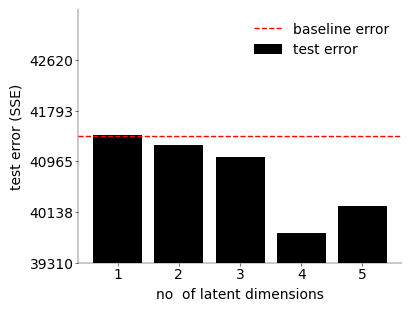

In [15]:
# -------------------------------------------------------------------------
# Compute and plot the test errors for the different latent variable models
# and answer the questions below (1+1 pts)
# -------------------------------------------------------------------------
# Your plot here
fig, ax = plt.subplots(figsize=(4, 3))

# barplot model error
ax.bar(
    np.arange(1, xval.maxXdim + 1),
    xval.errs,
    label="test error",
    color="black",
)

# plot baseline
ax.axhline(baseline, linestyle="--", c="red", label="baseline error")
ax.legend(loc="upper right")
ax.set_xlabel("no  of latent dimensions")
ax.set_ylabel("test error (SSE)")
ax.set_ylim(0.95 * baseline, 1.05 * baseline)
ax.set_yticks(
    np.arange(0.95 * baseline, 1.05 * baseline, (1.05 * baseline - 0.95 * baseline) / 5)
);

### Questions

Is the baseline error (0 latents) about what you expect in relation to the other models? Why or why not?

it is very unexpected that 1-3 latent dimensions give no or very little improvement

Can you identify a "best model". If so, which is it and what does this say about the structure of the latent state?

_YOUR ANSWER GOES HERE_

## Task 3. Visualization: population rasters and latent state.
Use the model with a single latent state. 

Create a raster plot where you show for each trial the spikes of all neurons as well as the trajectory of the latent state `x` (take care of the correct time axis). Sort the neurons by their weights `c_k`. Plot only the first 20 trials.

*Grading: 2 pts*

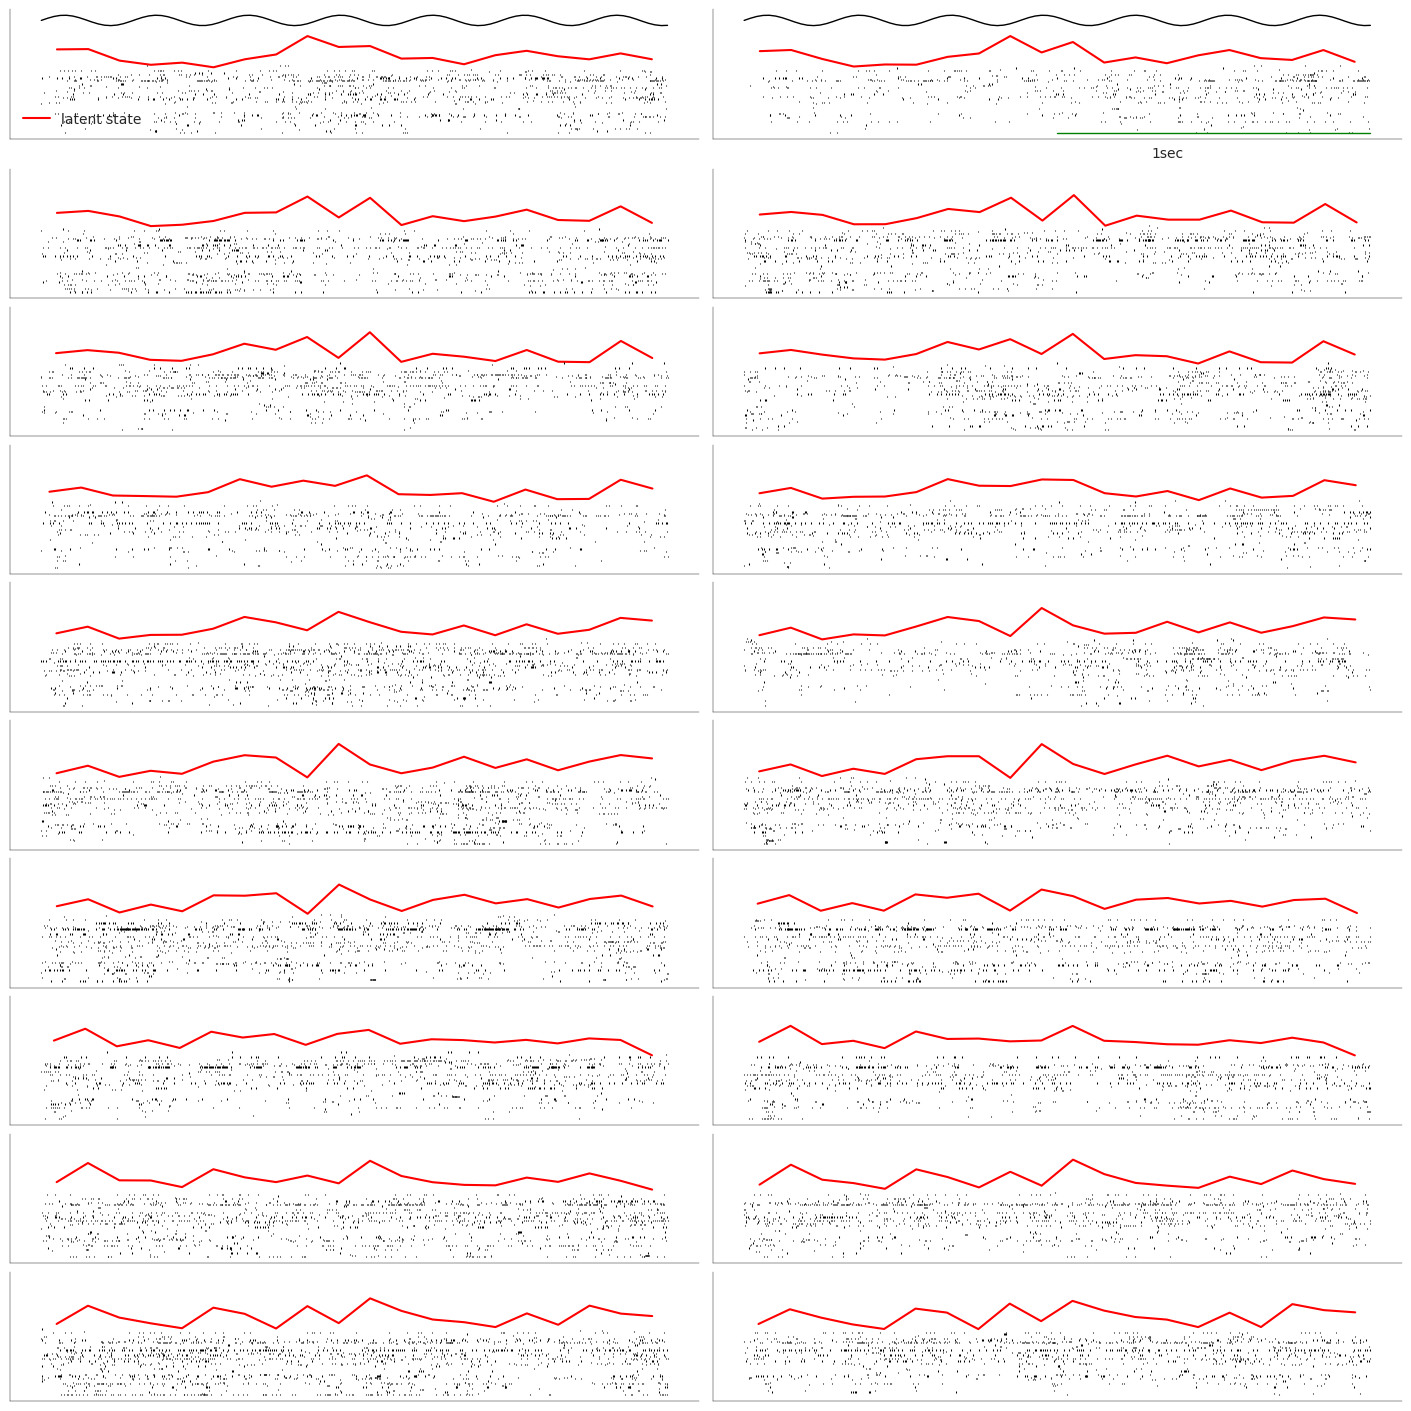

In [51]:
from numpy import matlib

# Your plot here
fig, axs = plt.subplots(10, 2, figsize=(14, 14), sharey=True)

ts = np.linspace(0, 2000, 100)
xa = 0.15
xs = 0.7 * xa * np.sin(ts / 1000 * 3.4 * 2 * np.pi) + xa


x_est = allTrialsState(xval.fits[0], 1).reshape(20, -1)

with sns.axes_style("ticks"):
    for ntrial, ax in enumerate(axs.flat):
        x = range(50, 2000, 100)  # assume binsize of 100ms

        # --------------------------------------------------------
        # plot the raster for each neuron and latent state (2 pts)
        # --------------------------------------------------------
        # latent states
        # hint: can be plotted on top of the corresponding raster
        # add vertical offset to latent states
        ax.plot(
            x,
            x_est[:, ntrial] * 5 + 35,
            color="red",
            linewidth=1.5,
            label="latent state",
        )

        # sort neurons by weight
        sorted_idx = np.argsort(xval.fits[0].optimParams["C"].flatten())

        for n, neuron in enumerate(data.data[ntrial]["spike_time"][sorted_idx]):
            # only spikes in the range 0-2000ms
            spikes = neuron[(neuron >= 0) & (neuron <= 2000)]
            ax.vlines(
                spikes,
                n - 30,
                n + 1 - 30,
                color="black",
                linewidth=0.75,
            )

        if ntrial == 0:
            ax.legend()
        if ntrial == 1:
            ax.plot([1000, 2000], [-30, -30], color="green")
            ax.text(1300, -50, "1sec")
        if ntrial < 2:
            ax.plot(ts, (xs * 40) + data.ydim, color="black")

        ax.set_yticks([])
        ax.set_xticks([])

## Task 4. Visualization of covariance matrix.

Plot (a) the covariance matrix of the observed data as well as its approximation using (b) one and (c) five latent variable(s). Use the analytical solution for the covariance matrix of the approximation*. Note that the solution is essentially the mean and covariance of the [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).

$ \mu = \exp(\frac{1}{2} \text{ diag}(CC^T)+d)$

$ \text{Cov}= \mu\otimes\mu^T \odot \exp(CC^T)+\mu\cdot \mathbb{I} - \mu\otimes\mu^T$ 

*[Krumin, M., and Shoham, S. (2009). Generation of Spike Trains with Controlled Auto- and Cross-Correlation Functions. Neural Computation 21, 1642–1664](http://www.mitpressjournals.org/doi/10.1162/neco.2009.08-08-847).

*Grading: 3 pts*

In [149]:
fit = xval.fits[0]
C, d = fit.optimParams["C"], fit.optimParams["d"][:, np.newaxis]

In [150]:
S = 0.5 * np.diag(C @ C.T)[:, np.newaxis]
mu = np.exp(S + d)

In [142]:
c = np.exp((d + d.T) + (S + S.T)) + (np.exp(C @ C.T) - 1)

In [ ]:
(mu * mu.T) * np.exp(C @ C.T) + mu * np.eye(mu.size, mu.size) - (mu * mu.T)

In [ ]:
# variant one. equations from above
def cov(fit: engine.PPGPFAfit) -> np.ndarray:
    C, d = fit.optimParams["C"], fit.optimParams["d"][:, np.newaxis]
    S = 0.5 * np.diag(C @ C.T)[:, np.newaxis]
    mu = np.exp(S + d)
    c = (mu * mu.T) * np.exp(C @ C.T) + mu * np.eye(mu.size, mu.size) - (mu * mu.T)
    return c, mu

In [ ]:
# variant two, equations from wikipedia
def cov(fit: engine.PPGPFAfit) -> np.ndarray:
    fit = xval.fits[0]
    C, d = fit.optimParams["C"], fit.optimParams["d"][:, np.newaxis]
    S = 0.5 * np.diag(C @ C.T)[:, np.newaxis]
    mu = np.exp(S + d)
    c = np.exp((d + d.T) + (S + S.T)) + (np.exp(C @ C.T) - 1)
    return c, mu

Text(0.5, 1.0, 'Covariance with 5 latent variables')

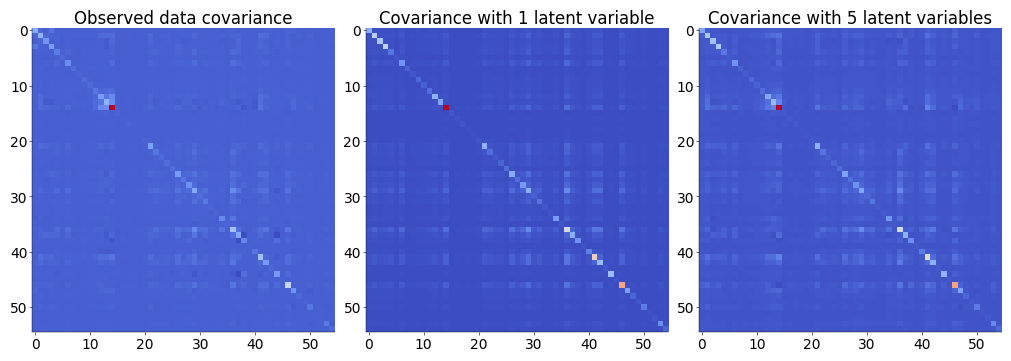

In [ ]:
# --------------------------------------------------------------
# Complete the analytical solution for the covariance matrix of
# the approximation using the provide equations (2 pts)
# --------------------------------------------------------------



# --------------------------------------------------------------
# Plot the covariance matrix ofa
# (1) the observed data
# (2) its approximation using 1 latent variable
# (3) its approximation using 5 latent variable
# and explain how they compare (1+1 pts).
# --------------------------------------------------------------

obs_corr = np.cov(data.all_raster)
opt_r1, mu1 = cov(xval.fits[0])
opt_r5, mu5 = cov(xval.fits[4])

# HINT: Think about which type of colormap and ranges are appropriate here.

fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))
# add plot to visualize the differences in the covariance matrices
# Determine the global maximum value across all matrices

# Now use vmin and vmax for all imshow calls below
axs[0].imshow(
    obs_corr,
    cmap="coolwarm",
    aspect="auto",
)
axs[0].set_title("Observed data covariance")
axs[1].imshow(
    opt_r1,
    cmap="coolwarm",
    aspect="auto",
)
axs[1].set_title("Covariance with 1 latent variable")
axs[2].imshow(
    opt_r5,
    cmap="coolwarm",
    aspect="auto",
)
axs[2].set_title("Covariance with 5 latent variables")

### Questions

What do you see / expect to see?

_YOUR ANSWER GOES HERE_